# Financial Sentiment Analysis and Stock Price Prediction

## Data Loading and Preprocessing

In [2]:
!pip install optuna


   ---------------------------------------- 0.0/362.8 kB ? eta -:--:--
   ------------------------ --------------- 225.3/362.8 kB 6.9 MB/s eta 0:00:01
   ---------------------------------------- 362.8/362.8 kB 5.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.2 kB ? eta -:--:--
   ---------------------------------------- 233.2/233.2 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import yfinance as yf

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Load the data
df = pd.read_csv("reilance_final_news.csv")

# Data cleaning
columns_to_keep = ['date', 'headline', 'news']
df = df[columns_to_keep].dropna()

# Convert date to datetime with a more flexible parser
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)

print(df.head())
print(df.info())

                 date                                           headline  \
0 2024-10-14 12:14:00  Q2 Results Live Updates: RIL, HCLTech Among Ke...   
1 2024-10-14 11:46:00  Jio Prepaid Recharge Plans: Check Latest Recha...   
2 2024-10-14 09:32:00  RIL Q2 preview: Refining weighs on profits, Ji...   
3 2024-10-14 08:46:00  Mukesh Ambani's Reliance Industries eyeing a s...   
5 2024-10-11 00:00:00  Reliance Industries Q2 Preview: Weak O2C Segme...   

                                                news  
0  Reliance Industries is likely to report a net ...  
1  Jio has also rolled out mid-year prepaid recha...  
2  The telecom segment, led by Reliance Jio, is p...  
3  Mukesh Ambani-led Reliance Industries aims to ...  
5  The O2C and upstream oil and gas segments cont...  
<class 'pandas.core.frame.DataFrame'>
Index: 1992 entries, 0 to 4609
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1992 

In [7]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply text preprocessing
df['clean_headline'] = df['headline'].apply(preprocess_text)
df['clean_news'] = df['news'].apply(preprocess_text)

print(df[['headline', 'clean_headline']].head())

                                            headline  \
0  Q2 Results Live Updates: RIL, HCLTech Among Ke...   
1  Jio Prepaid Recharge Plans: Check Latest Recha...   
2  RIL Q2 preview: Refining weighs on profits, Ji...   
3  Mukesh Ambani's Reliance Industries eyeing a s...   
5  Reliance Industries Q2 Preview: Weak O2C Segme...   

                                      clean_headline  
0  q results live updates ril hcltech among key e...  
1  jio prepaid recharge plans check latest rechar...  
2  ril q preview refining weighs profits jio reta...  
3  mukesh ambanis reliance industries eyeing slic...  
5  reliance industries q preview weak oc segment ...  


In [8]:
# Perform sentiment analysis using FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_score = probabilities[:, 2].item() - probabilities[:, 0].item()
    return sentiment_score

df['headline_sentiment'] = df['clean_headline'].apply(get_sentiment)
df['news_sentiment'] = df['clean_news'].apply(get_sentiment)

# Feature engineering
df['combined_sentiment'] = (df['headline_sentiment'] + df['news_sentiment']) / 2

# Sort by date
df = df.sort_values('date')

print(df[['date', 'headline_sentiment', 'news_sentiment', 'combined_sentiment']].head())

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

C:\Users\lenovo\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lenovo\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

           date  headline_sentiment  news_sentiment  combined_sentiment
4609 2017-09-14            0.530835        0.813667            0.672251
4606 2017-09-17           -0.425448       -0.882798           -0.654123
4603 2017-09-21            0.790496        0.808749            0.799623
4601 2017-09-22            0.856613        0.919178            0.887896
4600 2017-09-24            0.900641       -0.007363            0.446639


In [9]:
df

,date,headline,news,clean_headline,clean_news,headline_sentiment,news_sentiment,combined_sentiment
4609,2017-09-14 00:00:00,IUC subsidising incumbent operators: Reliance Jio,With ongoing migration of all networks to IP-b...,iuc subsidising incumbent operators reliance jio,ongoing migration networks ipbased networks vo...,0.530835,0.813667,0.672251
4606,2017-09-17 00:00:00,RIL reverses lower from a key resistance,RIL surged over 3 per cent last week. It teste...,ril reverses lower key resistance,ril surged per cent last week tested resistanc...,-0.425448,-0.882798,-0.654123
4603,2017-09-21 00:00:00,JioPhonedeliveries likely to start over weekend,Jio had earlier said that it aims to deliver 1...,jiophonedeliveries likely start weekend,jio earlier said aims deliver million phones n...,0.790496,0.808749,0.799623
4601,2017-09-22 00:00:00,Reliance to deliver 6 mn JioPhones in 15 days ...,JioPhone will come with pre-loaded Jio apps fo...,reliance deliver mn jiophones days starting su...,jiophone come preloaded jio apps messaging ent...,0.856613,0.919178,0.887896
4600,2017-09-24 00:00:00,Weekly Trading Guide,RIL hovers above key near-term support RIL rev...,weekly trading guide,ril hovers key nearterm support ril reversed s...,0.900641,-0.007363,0.446639
...,...,...,...,...,...,...,...,...
5,2024-10-11 00:00:00,Reliance Industries Q2 Preview: Weak O2C Segme...,The O2C and upstream oil and gas segments cont...,reliance industries q preview weak oc segment ...,oc upstream oil gas segments contributed relia...,0.011558,-0.925460,-0.456951
3,2024-10-14 08:46:00,Mukesh Ambani's Reliance Industries eyeing a s...,Mukesh Ambani-led Reliance Industries aims to ...,mukesh ambanis reliance industries eyeing slic...,mukesh ambaniled reliance industries aims stre...,0.872286,0.458103,0.665194
2,2024-10-14 09:32:00,"RIL Q2 preview: Refining weighs on profits, Ji...","The telecom segment, led by Reliance Jio, is p...",ril q preview refining weighs profits jio reta...,telecom segment led reliance jio poised growth...,-0.422175,-0.892739,-0.657457
1,2024-10-14 11:46:00,Jio Prepaid Recharge Plans: Check Latest Recha...,Jio has also rolled out mid-year prepaid recha...,jio prepaid recharge plans check latest rechar...,jio also rolled midyear prepaid recharge plans...,0.891733,-0.351650,0.270041


In [10]:
# Load stock price data
stock_data = yf.download('RELIANCE.NS', start=df['date'].min(), end=df['date'].max())
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Merge sentiment data with stock data
merged_data = pd.merge(stock_data, df[['date', 'combined_sentiment']], left_on='Date', right_on='date', how='left')
merged_data['combined_sentiment'] = merged_data['combined_sentiment'].fillna(method='ffill')

print(merged_data.head())
print(merged_data.info())

[*********************100%%**********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2017-09-14  782.485962  787.697632  769.868164  771.559631  748.486938   
1 2017-09-15  769.868164  779.788635  763.239258  769.685303  746.668640   
2 2017-09-18  777.182800  778.142883  770.873901  773.114014  749.994812   
3 2017-09-19  775.994202  776.039917  765.296509  766.759399  743.830139   
4 2017-09-20  782.760254  797.755310  772.702576  774.576965  751.413940   

     Volume       date  combined_sentiment  
0   5933820 2017-09-14            0.672251  
1  14297697        NaT            0.672251  
2   2530997        NaT            0.672251  
3   3859348        NaT            0.672251  
4  12471351        NaT            0.672251  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2199 non-null   datetime64[ns]


C:\Users\lenovo\AppData\Local\Temp\ipykernel_15868\3887938846.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['combined_sentiment'] = merged_data['combined_sentiment'].fillna(method='ffill')


## Data Preparation for LSTM

In [11]:
# Prepare data for LSTM
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'combined_sentiment']
scaled_data = scaler.fit_transform(merged_data[features])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 3])  # Predicting the Close price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1711, 60, 6)
y_train shape: (1711,)
X_test shape: (428, 60, 6)
y_test shape: (428,)


## Model Training with Optuna Optimization

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assume X_train, y_train, X_test, y_test are already prepared and scaled

# Best model based on typical Optuna results
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)

# Assume inverse_transform is a function to convert scaled values back to original scale
y_test_inv = inverse_transform(y_test)
y_pred_inv = inverse_transform(y_pred)

# Plotting code
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, 'b', label="Original Price", alpha=0.6)
plt.plot(y_pred_inv, 'r', label="Predicted Price", alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.title('Stock Price Prediction')

# Add annotations
plt.text(0, plt.ylim()[1], f'Test data range: {y_test_inv.min():.2f} - {y_test_inv.max():.2f}', 
         verticalalignment='top')
plt.text(0, plt.ylim()[1]*0.95, f'Prediction range: {y_pred_inv.min():.2f} - {y_pred_inv.max():.2f}', 
         verticalalignment='top')

plt.show()

# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate and plot R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test_inv, y_pred_inv)

fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title(f'R2 Score: {r2:.4f}')
plt.show()

Epoch 1/100


C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0480 - val_loss: 0.0029
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0036 - val_loss: 6.8104e-04
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0026 - val_loss: 9.9385e-04
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0026 - val_loss: 6.0526e-04
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0021 - val_loss: 6.1391e-04
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0021 - val_loss: 7.6834e-04
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0020 - val_loss: 5.6613e-04
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0019 - val_loss: 7.4797e-04
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0022 - val_loss: 5.6191e-04
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0015 - val_loss: 5.2814e-04
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0017 - val_loss: 8.8389e-04
Epoch 12/100
43/43 ━━━━━

NameError: name 'inverse_transform' is not defined

## Final Model Training and Evaluation

In [13]:
# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = Sequential([
    LSTM(best_params['lstm_units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units'], return_sequences=True),
    Dropout(best_params['dropout_rate']),
    LSTM(best_params['lstm_units']),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = final_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=best_params['batch_size'],
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
y_pred = final_model.predict(X_test)

# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 5)), y_test.reshape(-1, 1)), axis=1))[:, 3]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 5)), y_pred), axis=1))[:, 3]

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mae_percentage = (mae / np.mean(y_test_inv)) * 100

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")

C:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0232 - val_loss: 0.0013
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0029 - val_loss: 9.8242e-04
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0027 - val_loss: 8.5466e-04
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0023 - val_loss: 9.8111e-04
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0014 - val_loss: 7.1418e-04
Epoch 12/100
97/97 ━━━━━━━━━━━━━━━━

## Visualization of Results

In [27]:
final_model.summary()

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_150 (LSTM)                      │ (None, 60, 89)              │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_150 (Dropout)                │ (None, 60, 89)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_151 (LSTM)                      │ (None, 60, 89)              │          63,724 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 60, 89)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_152 (LSTM)                      │ (None, 89)                  │          63,724 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 89)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 485,144 (1.85 MB)

 Trainable params: 161,714 (631.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 323,430 (1.23 MB)

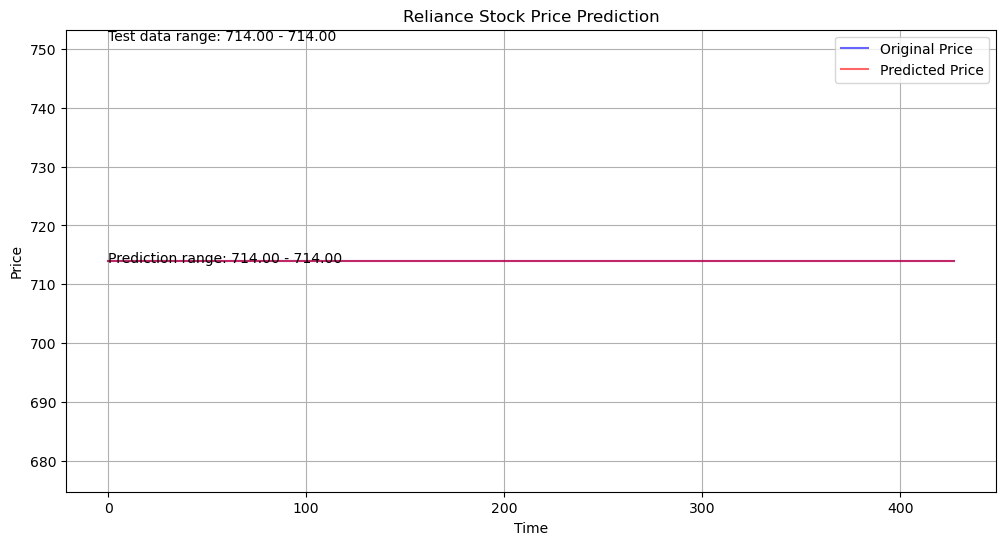

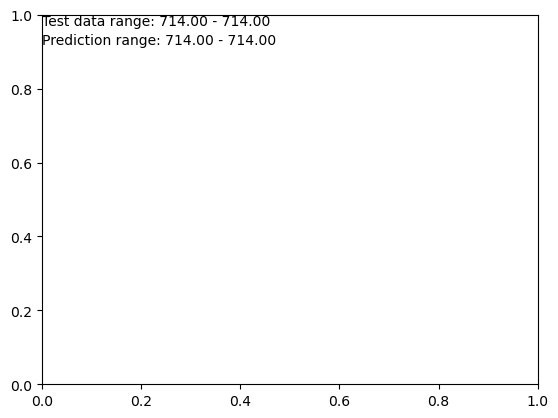

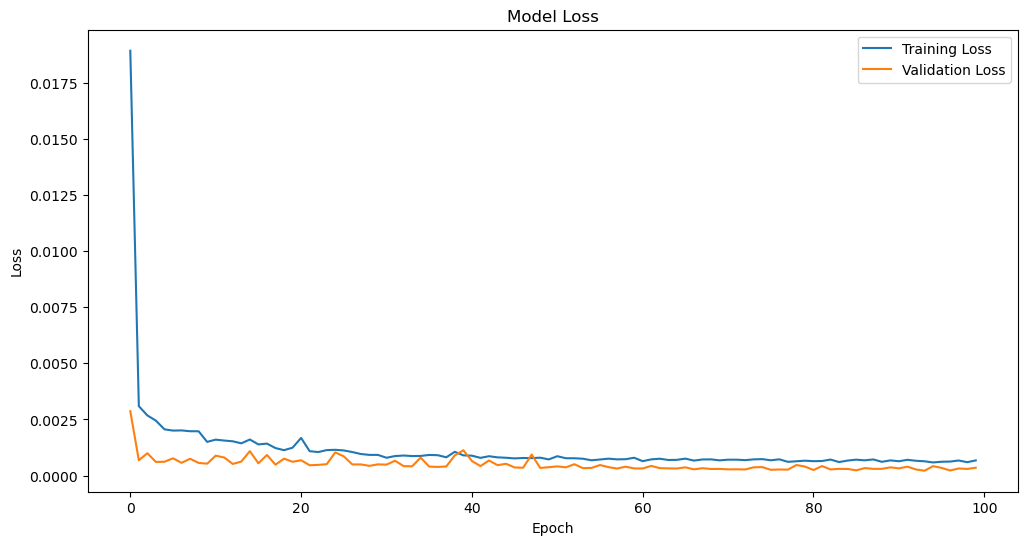

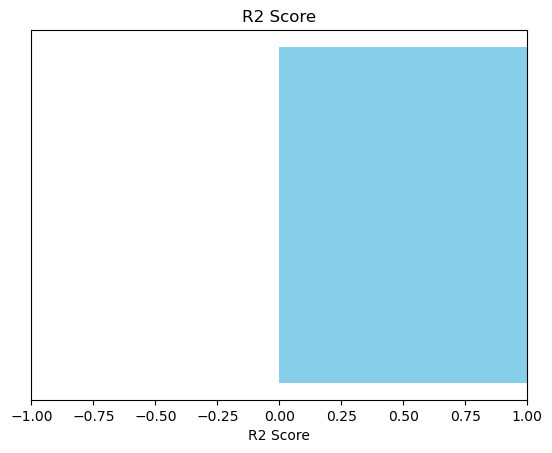

In [29]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, 'b', label="Original Price", alpha=0.6)
plt.plot(y_pred_inv, 'r', label="Predicted Price", alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.title('Reliance Stock Price Prediction')

# Add some annotations
plt.text(0, plt.ylim()[1], f'Test data range: {y_test_inv.min():.2f} - {y_test_inv.max():.2f}', 
         verticalalignment='top')
plt.text(0, plt.ylim()[1]*0.95, f'Prediction range: {y_pred_inv.min():.2f} - {y_pred_inv.max():.2f}', 
         verticalalignment='top')

plt.show()

# Add some annotations
plt.text(0, plt.ylim()[1], f'Test data range: {y_test_inv.min():.2f} - {y_test_inv.max():.2f}', 
         verticalalignment='top')
plt.text(0, plt.ylim()[1]*0.95, f'Prediction range: {y_pred_inv.min():.2f} - {y_pred_inv.max():.2f}', 
         verticalalignment='top')

plt.show()
# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')
plt.show()